# 互评作业2——频繁模式与关联规则挖掘

## 1 数据集概述

选用Wine数据集，在数据集中采用更新版本v2进行分析，该数据集共有129971条数据，13项属性标签，分别是：

* country：葡萄酒产出国
* description：侍酒师对葡萄酒风味的描述
* designation：葡萄园（酿酒厂指定的葡萄来源）
* points：《Wine Enthusiast Magazine》对葡萄酒的评分（1-100分）
* price：一瓶酒的价格
* province：葡萄酒来自的省或州
* region_1：省或州的葡萄种植产区
* region_2：葡萄种植产区内更特定的划分区域
* taster_name：品酒师姓名
* taster_twitter_handle：品酒师的Twitter账号
* title：葡萄酒评论的标题
* variety：葡萄品种
* winery：酿酒厂

## 2 处理数据集，转换为适合进行关联规则挖掘的形式

* 数据分析工具：Numpy，Pandas
* 读取数据，进行缺失值处理

In [1]:
# 导入要引的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 内嵌画图
%matplotlib inline

导入并预览前几条数据。数据位于 data/WineReviews/winemag-data-130k-v2.csv 这个CSV文件中，使用Pandas库中的read_csv()方法将CSV文件的内容加载到Pandas DataFrame()对象中。

In [2]:
wine_data = pd.read_csv('.\data\WineReviews\winemag-data-130k-v2.csv', sep=",", index_col = 0)
wine_data =wine_data.dropna()
wine_data.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath


可以看到points和price为数值属性，为了使得该数据集适用于关联规则挖掘，对数据需要进行简单的重构，接下来要将连续数值离散化。

### 2.1 离散化数值

先查看属性Points和Price的五数概括

In [3]:
num_data = ['points','price']
wine_data[num_data].describe()

,points,price
count,22387.000000,22387.000000
mean,89.537812,41.465404
std,2.809306,29.379374
min,80.000000,4.000000
25%,88.000000,25.000000
50%,90.000000,36.000000
75%,92.000000,50.000000
max,100.000000,2013.000000


根据上述结果，根据数值的大小，将Points和Price分成4个等级，表示评分的高低及价格的高低：

* points：低度（0-88），中低度（88-90）,中度（90-92），高度（92-100）
* price：低价（0-25），中低价（25-36），中价（36-50），高价（50-2013）

分级后Points的结果如下：

In [4]:
bin = [0,88,90,92,100]
wine_data['points'] = pd.cut(wine_data['points'],bin)
wine_data['points'] = wine_data['points'].astype('str')
wine_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,"(0, 88]",65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,"(0, 88]",19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
23,US,This wine from the Geneseo district offers aro...,Signature Selection,"(0, 88]",22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,"(0, 88]",69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
35,US,As with many of the Erath 2010 vineyard design...,Hyland,"(0, 88]",50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath


分级后Price的结果如下：

In [5]:
bin = [0,25,36,50,2013]
wine_data['price'] = pd.cut(wine_data['price'],bin)
wine_data['price'] = wine_data['price'].astype('str')
wine_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,"(0, 88]","(50, 2013]",Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,"(0, 88]","(0, 25]",California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
23,US,This wine from the Geneseo district offers aro...,Signature Selection,"(0, 88]","(0, 25]",California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,"(0, 88]","(50, 2013]",California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
35,US,As with many of the Erath 2010 vineyard design...,Hyland,"(0, 88]","(36, 50]",Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath


选取属性Points、Price、Country和Winery进行挖掘

In [6]:
wine_data = wine_data[['points','price','country','winery']]
wine_data.head(5)

,points,price,country,winery
4,"(0, 88]","(50, 2013]",US,Sweet Cheeks
10,"(0, 88]","(0, 25]",US,Kirkland Signature
23,"(0, 88]","(0, 25]",US,Bianchi
25,"(0, 88]","(50, 2013]",US,Castello di Amorosa
35,"(0, 88]","(36, 50]",US,Erath


## 3 找出频繁模式

此处利用Apriori算法先找出所有的频繁项集

In [7]:
def createC1( dataSet ):
    C1 = []
    for transaction in np.array(dataSet):
        for item in transaction:
            if [item] not in C1:
                C1.append( [item] )
    C1.sort()
    return list(map( frozenset, C1 ))

def scanD( D, Ck, minSupport ):
    ssCnt = {}
    for tid in D:
        if Ck is not None:
            for can in Ck:
                if can.issubset( tid ):
                    ssCnt[ can ] = ssCnt.get( can, 0) + 1
    numItems = float( len( D ) )
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[ key ] / numItems
        if support >= minSupport:
            retList.insert( 0, key )
            supportData[ key ] = support
    return retList, supportData

In [8]:
def aprioriGen( Lk, k ):
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()    
            if L1==L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    C1 = createC1( dataSet )
    D =list( map( set, dataSet ))
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        suppData.update( supK )
        L.append( Lk )
        k += 1
    return L, suppData

下列则是所有的频繁项集：

In [9]:
newData = list(map(set,np.array(wine_data)))
L, suppData = apriori(newData, 0.05)
L

[[frozenset({'(0, 88]'}),
  frozenset({'US'}),
  frozenset({'(50, 2013]'}),
  frozenset({'(92, 100]'}),
  frozenset({'(25, 36]'}),
  frozenset({'(90, 92]'}),
  frozenset({'(88, 90]'}),
  frozenset({'(0, 25]'}),
  frozenset({'(36, 50]'})],
 [frozenset({'(36, 50]', '(90, 92]'}),
  frozenset({'(25, 36]', '(88, 90]'}),
  frozenset({'(36, 50]', 'US'}),
  frozenset({'(0, 25]', '(0, 88]'}),
  frozenset({'(88, 90]', 'US'}),
  frozenset({'(25, 36]', 'US'}),
  frozenset({'(50, 2013]', 'US'}),
  frozenset({'(0, 25]', 'US'}),
  frozenset({'(0, 88]', '(36, 50]'}),
  frozenset({'(50, 2013]', '(92, 100]'}),
  frozenset({'(0, 88]', 'US'}),
  frozenset({'(90, 92]', 'US'}),
  frozenset({'(0, 25]', '(88, 90]'}),
  frozenset({'(0, 88]', '(25, 36]'}),
  frozenset({'(36, 50]', '(88, 90]'}),
  frozenset({'(50, 2013]', '(90, 92]'}),
  frozenset({'(25, 36]', '(90, 92]'}),
  frozenset({'(92, 100]', 'US'})],
 [frozenset({'(0, 25]', '(88, 90]', 'US'}),
  frozenset({'(25, 36]', '(90, 92]', 'US'}),
  frozenset({'(5

## 4 导出关联规则，计算支持度和置信度，并对关联规则进行评价

In [10]:
for tmp, num in suppData.items():
    print(tmp, ':', num)

frozenset({'(90, 92]'}) : 0.24514227006744985
frozenset({'US', '(90, 92]', '(25, 36]'}) : 0.055165944521374015
frozenset({'(0, 88]'}) : 0.3699468441506231
frozenset({'US', '(92, 100]'}) : 0.14771965873051324
frozenset({'US', '(90, 92]', '(50, 2013]'}) : 0.07450752668959663
frozenset({'US', '(90, 92]', '(36, 50]'}) : 0.08433465850716934
frozenset({'(90, 92]', '(25, 36]'}) : 0.055165944521374015
frozenset({'(0, 25]'}) : 0.2844061285567517
frozenset({'(88, 90]', '(36, 50]'}) : 0.0621789431366418
frozenset({'US', '(88, 90]', '(25, 36]'}) : 0.06508241390092465
frozenset({'(0, 88]', '(25, 36]'}) : 0.09501049716353241
frozenset({'(50, 2013]'}) : 0.23187564211372672
frozenset({'(36, 50]'}) : 0.25318265064546386
frozenset({'(0, 25]', '(88, 90]'}) : 0.06771787197927369
frozenset({'(92, 100]'}) : 0.14771965873051324
frozenset({'US', '(88, 90]', '(36, 50]'}) : 0.0621789431366418
frozenset({'US', '(90, 92]'}) : 0.24514227006744985
frozenset({'US', '(92, 100]', '(50, 2013]'}) : 0.08308393263947828
f

In [11]:
'''
输入频繁项集列表、频繁项集的支持度字典、最小置信度

输出包含置信度的规则列表
'''
def generateRules(L, supportData, minConf=0.5):
    bigRuleList = []
    for i in range(1, len(L)):
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]   #规则后件集合
            if (i > 1):
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)
    return bigRuleList

#生成候选规则集合
def calcConf(freqSet, H, supportData, brl, minConf=0.5):
    prunedH = []
    for conseq in H:
        conf = supportData[freqSet]/supportData[freqSet-conseq]   #集合相减
        if conf >= minConf:
            print('{freqSet-conseq} --> {conseq} conf:{conf}'+ 'support: '+ str(supportData[freqSet]))
            brl.append((freqSet-conseq, conseq, conf, supportData[freqSet]))
            prunedH.append(conseq)
    return prunedH

#对规则进行评估
def rulesFromConseq(freqSet, H, supportData, brl, minConf=0.5):
    m = len(H[0])
    if (len(freqSet) > (m + 1)):
        Hmp1 = aprioriGen(H, m+1)
        Hmp1 = calcConf(freqSet, Hmp1, supportData, brl, minConf)
        if (len(Hmp1) > 1):
            rulesFromConseq(freqSet, Hmp1, supportData, brl, minConf)

关联规则及其置信度和支持度如下：

In [12]:
rules = generateRules(L, suppData, minConf=0.05)

{freqSet-conseq} --> {conseq} conf:{conf}support: 0.08433465850716934
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.08433465850716934
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.06508241390092465
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.06508241390092465
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.25318265064546386
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.25318265064546386
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.18064055031938178
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.18064055031938178
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.23719122705141377
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.23719122705141377
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.23053557868405772
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.23053557868405772
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.23187564211372672
{freqSet-conseq} --> {conseq} conf:{conf}support: 0.23187564211372672
{freqSet-conseq} -->

## 5 对规则进行评价

### 5.1 利用Lift进行评价

In [13]:
def getlift(rules, suppData):
    lift = []
    for rule in rules:
        freqSet_conseq = rule[0]
        conseq = rule[1]
        lift_val = float(rule[3]) / float(suppData[rule[1]])
        lift.append([freqSet_conseq, conseq, lift_val])
    return lift

In [14]:
lift = getlift(rules, suppData)
lift

[[frozenset({'(36, 50]'}), frozenset({'(90, 92]'}), 0.34402332361516036],
 [frozenset({'(90, 92]'}), frozenset({'(36, 50]'}), 0.3330980945659845],
 [frozenset({'(25, 36]'}), frozenset({'(88, 90]'}), 0.2743879472693032],
 [frozenset({'(88, 90]'}), frozenset({'(25, 36]'}), 0.2823096299166828],
 [frozenset({'(36, 50]'}), frozenset({'US'}), 0.25318265064546386],
 [frozenset({'US'}), frozenset({'(36, 50]'}), 1.0],
 [frozenset({'(0, 25]'}), frozenset({'(0, 88]'}), 0.48828785317556145],
 [frozenset({'(0, 88]'}), frozenset({'(0, 25]'}), 0.6351499921470081],
 [frozenset({'(88, 90]'}), frozenset({'US'}), 0.23719122705141377],
 [frozenset({'US'}), frozenset({'(88, 90]'}), 1.0],
 [frozenset({'(25, 36]'}), frozenset({'US'}), 0.23053557868405772],
 [frozenset({'US'}), frozenset({'(25, 36]'}), 1.0],
 [frozenset({'(50, 2013]'}), frozenset({'US'}), 0.23187564211372672],
 [frozenset({'US'}), frozenset({'(50, 2013]'}), 1.0],
 [frozenset({'US'}), frozenset({'(0, 25]'}), 1.0],
 [frozenset({'(0, 25]'}), fro

### 5.2 利用全置信度进行评价

In [15]:
def all_confidence(rules,suppData):
    num = []
    for rule in rules:
        A = rule[0]
        B = rule[1]
        k = suppData[B]/max(suppData[A],suppData[B-A])
        num.append([A, B, k])
    return num

In [16]:
all_conf = all_confidence(rules, suppData)
all_conf

[[frozenset({'(36, 50]'}), frozenset({'(90, 92]'}), 0.9682427664079041],
 [frozenset({'(90, 92]'}), frozenset({'(36, 50]'}), 1.0],
 [frozenset({'(25, 36]'}), frozenset({'(88, 90]'}), 1.0],
 [frozenset({'(88, 90]'}), frozenset({'(25, 36]'}), 0.971939736346516],
 [frozenset({'(36, 50]'}), frozenset({'US'}), 1.0],
 [frozenset({'US'}), frozenset({'(36, 50]'}), 0.25318265064546386],
 [frozenset({'(0, 25]'}), frozenset({'(0, 88]'}), 1.0],
 [frozenset({'(0, 88]'}), frozenset({'(0, 25]'}), 0.7687756580536103],
 [frozenset({'(88, 90]'}), frozenset({'US'}), 1.0],
 [frozenset({'US'}), frozenset({'(88, 90]'}), 0.23719122705141377],
 [frozenset({'(25, 36]'}), frozenset({'US'}), 1.0],
 [frozenset({'US'}), frozenset({'(25, 36]'}), 0.23053557868405772],
 [frozenset({'(50, 2013]'}), frozenset({'US'}), 1.0],
 [frozenset({'US'}), frozenset({'(50, 2013]'}), 0.23187564211372672],
 [frozenset({'US'}), frozenset({'(0, 25]'}), 0.2844061285567517],
 [frozenset({'(0, 25]'}), frozenset({'US'}), 1.0],
 [frozenset

## 6 对挖掘结果分析和可视化

对支持度和置信度进行可视化

In [17]:
def show(x,y,title,K):
    plt.figure(figsize=(12,5)) 
    plt.xticks(rotation=270)
    plt.bar(x=x, height=y, label='d', color='steelblue', alpha=1)
    for xx, yy in zip(x, y):
        plt.text(xx, yy, str(yy), ha='center', va='bottom', fontsize=10, rotation=0)
    plt.title(title)
    plt.xlabel("rule")
    plt.ylabel(K)
    plt.show()

In [18]:
rule = []
sup = []
conf = []
for tmp in rules[:15]:
    rule.append(str(tmp[0])+"->"+str(tmp[1]))
    conf.append(round(tmp[2], 2))
    sup.append(round(tmp[3], 2))

### 1.6.1 支持度可视化

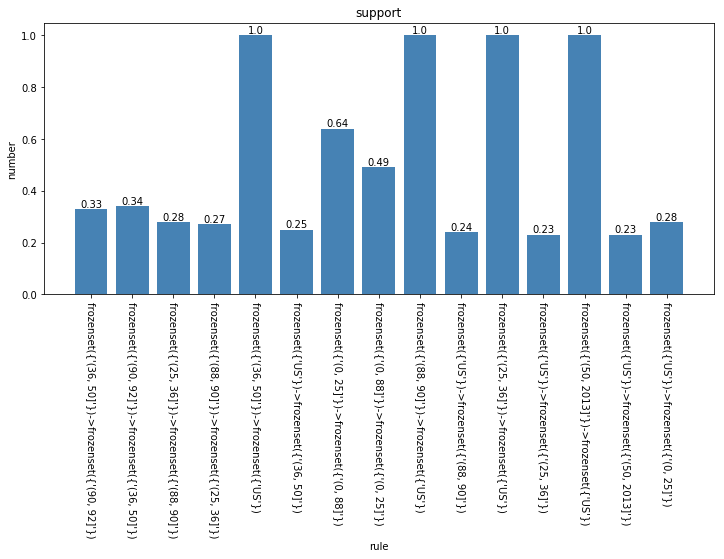

In [19]:
show(rule,conf,"support","number")

### 1.6.2 置信度可视化

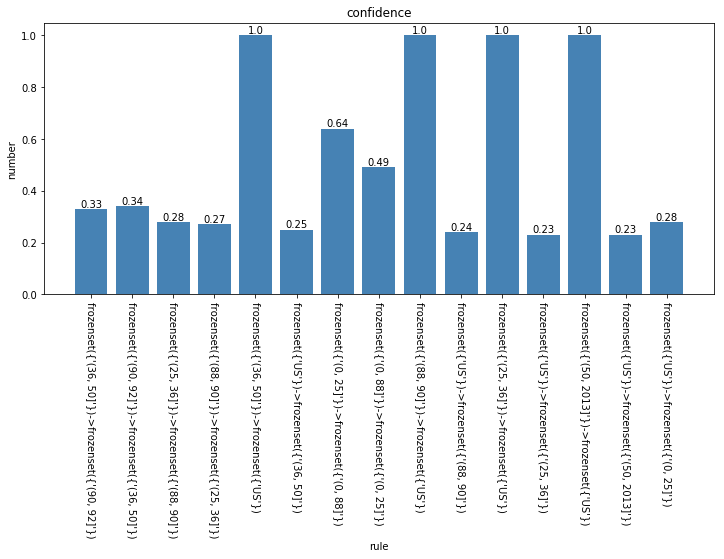

In [20]:
show(rule,conf,"confidence","number")